# Synchronous A2C

I used the codes from RL course at Aalto university and here: https://github.com/higgsfield/RL-Adventure-2/blob/master/1.actor-critic.ipynb


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

import gym
import matplotlib.pyplot as plt
import numpy as np

from multi_env import SubprocVecEnv

from IPython.display import clear_output

%matplotlib inline

In [2]:
class ActorCritic(nn.Module):
    def __init__(self, n_inputs, n_hiddens, n_outputs):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(n_inputs, n_hiddens)
        self.critic_head = nn.Linear(n_hiddens, 1)
        self.actor_head = nn.Linear(n_hiddens, n_outputs)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        value = self.critic_head(x)
        action_logits = self.actor_head(x)
        action_probs = F.softmax(action_logits)
        return action_probs, value

In [3]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

In [4]:

class A2CAgent(object):
    def __init__(self, actor_critic):
        self.train_device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.actor_critic = actor_critic.to(self.train_device)
        self.optimizer = torch.optim.RMSprop(self.actor_critic.parameters(), lr=5e-3)
        self.gamma = 0.98
        self.states = []
        self.action_probs = []
        self.rewards = []
        self.state_values = []
        self.next_state_values = []
        self.masks = []
        self.entropy = 0

    def do_update(self, next_state_value):
        action_probs = torch.cat(self.action_probs).to(self.train_device)
        state_values = torch.cat(self.state_values).to(self.train_device)
        rewards = self.rewards
        masks = self.masks
        entropy = self.entropy

        self.states, self.action_probs, self.rewards, self.state_values, self.masks = [], [], [], [], []
        self.entropy = 0

        returns = compute_returns(next_state_value, rewards, masks, self.gamma)
        returns = torch.cat(returns).detach()

        advantage = returns - state_values

        actor_loss = - (action_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        # scale of losses are different.
        loss = actor_loss + 0.1 * critic_loss - 0.001 * entropy

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_action_update_entropy(self, observation, evaluation=False):
        x = torch.from_numpy(observation).float().to(self.train_device)
        action_probs, values = self.actor_critic(x)

        if evaluation:
            return torch.argmax(action_probs)

        dist = Categorical(action_probs)
        self.entropy += dist.entropy().mean()
        action = dist.sample()
        act_log_prob = dist.log_prob(action)
        return action, act_log_prob, values

    def store_outcome(self, observation, action_prob, reward, state_value, mask):
        self.states.append(observation)
        self.action_probs.append(action_prob)
        self.rewards.append(reward)
        self.state_values.append(state_value)
        self.masks.append(mask)



In [5]:
# Create a Gym environment
env_name = 'CartPole-v0'
env = gym.make(env_name)

train_frams = 50000
num_steps = 5

[2019-11-17 12:31:47,561] Making new env: CartPole-v0
/home/isaac/miniconda3/envs/pytorch13/lib/python3.6/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [6]:
def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

num_envs = 8
envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

[2019-11-17 12:31:47,595] Making new env: CartPole-v0
[2019-11-17 12:31:47,601] Making new env: CartPole-v0
[2019-11-17 12:31:47,605] Making new env: CartPole-v0
[2019-11-17 12:31:47,610] Making new env: CartPole-v0
[2019-11-17 12:31:47,616] Making new env: CartPole-v0
[2019-11-17 12:31:47,625] Making new env: CartPole-v0
[2019-11-17 12:31:47,629] Making new env: CartPole-v0
[2019-11-17 12:31:47,634] Making new env: CartPole-v0


In [7]:
# Get dimensionalities of actions and observations
action_space_dim = env.action_space.n
observation_space_dim = env.observation_space.shape[-1]
print('action_space_dim: ', action_space_dim)
print('observation_space_dim: ', observation_space_dim)

hidden_size = 64

# Instantiate agent and its policy
actor_critic = ActorCritic(observation_space_dim, hidden_size, action_space_dim)
agent = A2CAgent(actor_critic)

action_space_dim:  2
observation_space_dim:  4


In [8]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    

def test_env(env, agent, device, vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        action = agent.get_action_update_entropy(state, evaluation=True)
        next_state, reward, done, _ = env.step(action.detach().cpu().numpy())
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward


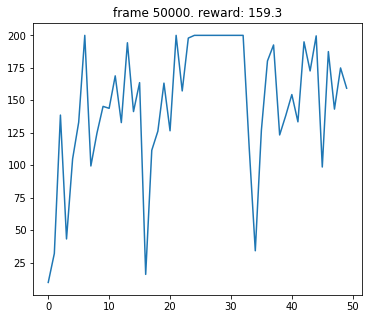

In [9]:
# Arrays to keep track of rewards
reward_history, timestep_history = [], []
average_reward_history = []

frame_idx = 0
test_rewards = []

observation = envs.reset()

# Run actual training
while frame_idx < train_frams:
    for step in range(num_steps):
        # Get action from the agent
        action, action_probabilities, state_value = agent.get_action_update_entropy(observation)
        previous_observation = observation

        # Perform the action on the environment, get new state and reward
        next_observation, reward, done, _ = envs.step(action.detach().cpu().numpy())

        mask = torch.FloatTensor(1 - done).unsqueeze(1).to(agent.train_device)
        reward = torch.FloatTensor(reward).unsqueeze(1).to(agent.train_device)

        # Store action's outcome (so that the agent can improve its policy)
        agent.store_outcome(previous_observation,
                            action_probabilities,
                            reward,
                            state_value,
                            mask)

        observation = next_observation
        frame_idx += 1

        if frame_idx % 1000 == 0:
            test_rewards.append(np.mean([test_env(env, agent, agent.train_device) for _ in range(10)]))
            plot(frame_idx, test_rewards)

    next_observation = torch.from_numpy(next_observation).float().to(agent.train_device)
    _, next_state_value = agent.actor_critic(next_observation)
    agent.do_update(next_state_value)
